In [16]:
import numpy as np
import matplotlib.pyplot as plt

# Setup 2D Ising Model
$$ H = -J \sum_{\langle i,j \rangle} s_i s_j $$
First, randomly set the spins to -1 or 1 at each lattice point.

In [ ]:
def initialize_spins(N):
    return np.random.choice([-1, 1], size=(N, N))

Make a function to calculate the magnetization (it's just the sum of the spins!)

In [ ]:
def calculate_magnetization(spins):
    return np.sum(spins)

Implement the Metropolis algorithm:
- Each step will have N^2 updates
- We randomly choose a lattice point using randint (1, 3) for example
- Then calculate the energy which it will cost us to flip the spin
- This calculation involves asking? Who are my neighbors at the lattice site? left, right, up, down
- We calculate a Boltzmann factor based on this energy.
- If the Boltzmmann factor is larger than some random number between 0 and 1 we accept the move

Seems kind of arbitrary right? Well it is a Monte Carlo algorithm, but besides that the intuitive reasoning I like to use is the following:
- We want to have a physically realistic simulation - use the Boltzmann factor
- We want to explore different configurations - let's randomly try to change the sites
- We could flip a coin to see if we should flipped the site, but we have something better : we can use a random number generator
- Now we subject our random number generator to the rule that "if it is less than what boltzmann would expect we accept"

There are certainly more rigorous approaches to explaining Metropolis, however I think that most difficult part to grasp is the random number generator + boltzmann part. It is a way of turning two continous values a random number and a distribution into a yes, no decision based on statistical mechanics.

In [17]:
def metropolis(spins, beta):
    N = spins.shape[0]
    for _ in range(N**2):  # Attempt N^2 updates per step
        i, j = np.random.randint(0, N, size=2)
        spin_flip_energy = 2 * spins[i, j] * (
            spins[(i+1)%N, j] + spins[(i-1)%N, j] +
            spins[i, (j+1)%N] + spins[i, (j-1)%N]
        )
        if spin_flip_energy <= 0 or np.random.rand() < np.exp(-spin_flip_energy * beta):
            spins[i, j] *= -1
    return spins


# Calculating the Binder Cumulant 
The Binder cumulant or Binder parameter is defined as $$ U = 1 - \frac{\langle m^4 \rangle}{3 \langle m^2 \rangle^2} $$ 

The typical way that it is used is to find a phase transition by varying the size of the system. The cumulant can be plotted as a function of an observable, say temperature and where the cumulant curves cross there is usually a phase transition.  

# Note on averages 
The angle bracket quantities refer to an average over the steps of the system. In the case of an Ising model this means that we calculate the magnetization (total number of spins) and average over the number of steps. Note that for the Binder cumulant we have $ {\langle m^4 \rangle} $ and  $ \langle m^2 \rangle^2 $ as the two statistical quantities we need to extract from our model. These averages are not the same. The $ {\langle m^4 \rangle} $ term means that we calculate the magnetization raise to the fourth power <em> then </em> average over the steps. $ \langle m^2 \rangle^2 $ means that we square the term, average over the steps and then square again.

# Thermalization steps
Often, an initial fraction of Monte-Carlo steps are discarded because the initial states are not very realistic. Remember that the model was randomly initialized, so it may not be close to thermal equilibrium. By removing these thermalization steps we can improve the accuracy of our final averages.

In [2]:
def calculate_cumulants(spins, beta, num_steps=10000, thermalization_steps=1000):
    N = spins.shape[0]
    magnetization = np.zeros(num_steps - thermalization_steps)
    magnetization_squared = np.zeros(num_steps - thermalization_steps)
    magnetization_fourth = np.zeros(num_steps - thermalization_steps)
    
    for step in range(num_steps):
        spins = metropolis(spins, beta)
        
        if step >= thermalization_steps:
            m = calculate_magnetization(spins)
            idx = step - thermalization_steps
            magnetization[idx] = m
            magnetization_squared[idx] = m**2
            magnetization_fourth[idx] = m**4
    
    magnetization_avg = np.mean(magnetization)
    magnetization_squared_avg = np.mean(magnetization_squared)
    magnetization_fourth_avg = np.mean(magnetization_fourth)
    
    binder_cumulant = 1 - magnetization_fourth_avg / (3 * magnetization_squared_avg**2)
    
    return magnetization_avg / N**2, binder_cumulant

# Performing the phase transition search
By using different lattice sizes we can use the Binder Cumulant to see where the phase transition is. The lattices sizes are kept small to make sure the simulation runs quickly, so the crossing over effect is not as pronounced as if one were to use 10, 20, 30, 40. Using axhline I just drew an approximate line where the lines were closest. If one looks at the temperature value corresponding to where the cumulant values cross, that also indicates the phase transition point.

Calculating for system size L=4
Calculating for system size L=5
Calculating for system size L=6


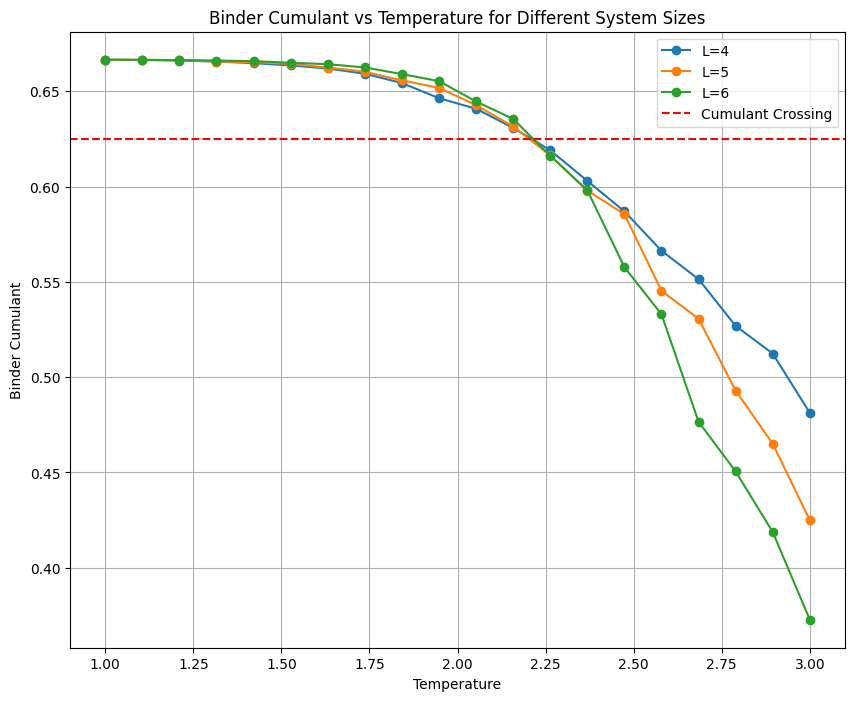

In [10]:
# Parameters
system_sizes = [4, 5, 6]  # Different system sizes
temperatures = np.linspace(1.0, 3.0, 20)  # Array of temperatures
num_steps = 10000  # Number of Monte Carlo steps
thermalization_steps = 1000  # Thermalization steps

# Arrays to store results for each system size
results = {size: {'mean_magnetization': [], 'binder_cumulant': []} for size in system_sizes}

# Calculate cumulants for each temperature and system size
for N in system_sizes:
    print(f"Calculating for system size L={N}")
    spins = initialize_spins(N)
    for temp in temperatures:
        beta = 1.0 / temp
        magnetization, binder = calculate_cumulants(spins.copy(), beta, num_steps, thermalization_steps)
        results[N]['mean_magnetization'].append(magnetization)
        results[N]['binder_cumulant'].append(binder)

# Plotting Binder Cumulant for different system sizes
plt.figure(figsize=(10, 8))
for N in system_sizes:
    plt.plot(temperatures, results[N]['binder_cumulant'], marker='o', linestyle='-', label=f'L={N}')
plt.axhline(y=0.625, color='r', linestyle='--', label='Cumulant Crossing')
plt.xlabel('Temperature')
plt.ylabel('Binder Cumulant')
plt.title('Binder Cumulant vs Temperature for Different System Sizes')
plt.legend()
plt.grid(True)
plt.show()


We can see that the mean magnetization moves from an oscillating regime to one where the mean magnetization is close to zero.

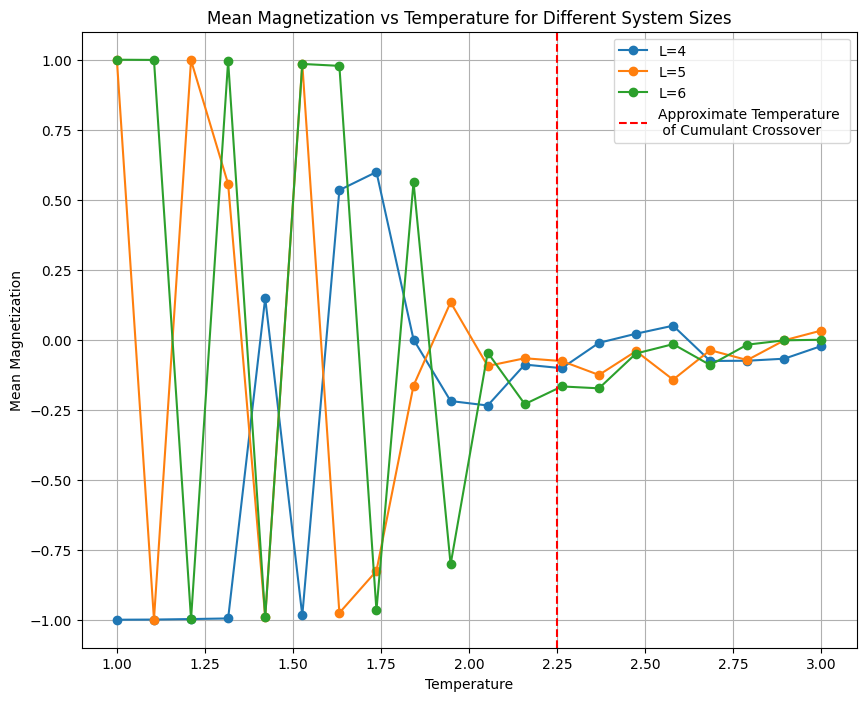

In [15]:
# Plotting Mean Magnetization for different system sizes
plt.figure(figsize=(10, 8))
for N in system_sizes:
    plt.plot(temperatures, results[N]['mean_magnetization'], marker='o', linestyle='-', label=f'L={N}')
plt.axvline(x=2.25, color='r', linestyle='--', label='Approximate Temperature \n of Cumulant Crossover')
plt.xlabel('Temperature')
plt.ylabel('Mean Magnetization')
plt.title('Mean Magnetization vs Temperature for Different System Sizes')
plt.legend()
plt.grid(True)
plt.show()